# MVN

In [22]:
import numpy as np
import scipy as sp
import scipy.stats

import theano
import theano.tensor as tt
import theano.tensor.slinalg
%matplotlib inline

In [23]:
mu = np.random.randn(100)*2
A = np.random.randn(100,100)
C = np.dot(A.T, A)
x = np.random.randn(100)

# using numpy, and solve_triangular
def mvn_logpdf(x, mu, C):
    diff = x - mu
    L = sp.linalg.cholesky(C, lower=True)
    tmp = sp.linalg.solve_triangular(L, diff, lower=True)
        
    logdet = 2.0 * np.sum(np.log(np.diag(L)))
    
    loglike = -0.5 * (np.dot(tmp.T, tmp) + logdet + len(x)*np.log(2*np.pi))
    return loglike

def mvn_logpdf_th(x, mu, C):
    chol = tt.slinalg.cholesky(C)
    delta = x - mu
    k = chol.shape[0]
    tmp = tt.slinalg.solve_lower_triangular(chol, delta)
    return -0.5 * (k * tt.log(2 * np.pi) +\
                   2.0 * tt.sum(tt.log(tt.nlinalg.diag(chol)))+\
                   tt.dot(tt.transpose(tmp), tmp))


print(mvn_logpdf(x, mu, C))
print(sp.stats.multivariate_normal.logpdf(x, mean=mu, cov=C))
print(theano.function([], mvn_logpdf_th(x, mu, C))())

-1162.44548603
-1162.44548603
-1162.445486026144


In [24]:
## Random draws with cholesky
def random_sample(mu, C, n):
    L = sp.linalg.cholesky(C, lower=True)
    return np.dot(L, np.random.randn(len(mu))) + mu
print(random_sample(mu, C, 100).shape)

(100,)


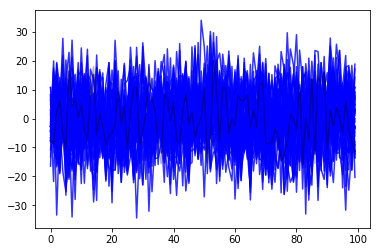

In [25]:
plt.plot(np.random.multivariate_normal(mu, C, 40).T, "b", alpha=0.8);
plt.plot(random_sample(mu, C, 40), "k", alpha=0.3);

# Kronecker version

In [26]:
import scipy.linalg as spla
A = np.random.randn(5,5)
Kt = np.dot(A.T, A)

A = np.random.randn(3,3)
Kx = np.dot(A.T, A)

Y = np.random.randn(3,5) # <----------------------------------- 92 x 950

def vec(Y):
    return Y.flatten(order="F")[:,None]

def devec(y):
    return y.reshape(Y.shape[0], Y.shape[1], order="F")

In [27]:
# test vec
print(devec(vec(Y)))
print(Y)

[[ 1.40849706 -0.91789048  0.47058867  1.33702694  0.38901509]
 [-1.13370349  1.78868386 -0.68359641 -0.62711997 -2.15558708]
 [ 1.0047877   0.44491973  0.63618983  1.74959286  1.15607274]]
[[ 1.40849706 -0.91789048  0.47058867  1.33702694  0.38901509]
 [-1.13370349  1.78868386 -0.68359641 -0.62711997 -2.15558708]
 [ 1.0047877   0.44491973  0.63618983  1.74959286  1.15607274]]


In [28]:
# true answer
K = np.kron(Kt, Kx) + np.eye(3*5)*1e-10
Ki = np.linalg.pinv(K)
print(np.dot(np.dot(vec(Y).T, Ki), vec(Y)))

[[ 4034891.64634851]]


In [29]:
# without kron structure, using choleskies
Lk = np.linalg.cholesky(K)
tmp = spla.solve_triangular(Lk, vec(Y), lower=True)
print(np.dot(tmp.T, tmp))

# solve without choleskies
print(np.dot(vec(Y).T, np.linalg.solve(K, vec(Y))))

[[ 4034891.64882965]]
[[ 4034891.6435367]]


In [30]:
# solve using kron structure
Lt = np.linalg.cholesky(Kt)
Lx = np.linalg.cholesky(Kx)

checking (from stegle 2011)
$$ (A \otimes B) \mathrm{vec}(Y) = B^T Y A $$

checking (from flaxman)
$$ (A \otimes B)^{-1} \mathrm{vec}(Y) = A^{-1} (Y B^{-1})^{T} $$

checking (from wikipedia kronecker product article)
$$ (B^{T} \otimes A) \mathrm{vec}(Y) = \mathrm{vec}(AYB) $$

In [31]:
print("Stegle true")
print(np.dot(np.kron(Kt, Kx), vec(Y)).T)

print("Stegle")
print(vec(np.dot(Kx, np.dot(Y, Kt))).T)

print("flaxman")
print(vec(np.dot(np.dot(np.linalg.pinv(Kx), Y), np.linalg.pinv(Kt))))

print("flaxman true")
print(np.dot(np.linalg.pinv(np.kron(Kt, Kx)), vec(Y)))

Stegle true
[[ 32.14873014 -33.54183751   4.28935087 -36.80064738  20.89609592
    4.85415434  -7.76742251  -3.22624465   5.28648273  -6.61726792
   -4.55909388   5.5123084   14.30675733 -48.88180624  20.84948762]]
Stegle
[[ 32.14873014 -33.54183751   4.28935087 -36.80064738  20.89609592
    4.85415434  -7.76742251  -3.22624465   5.28648273  -6.61726792
   -4.55909388   5.5123084   14.30675733 -48.88180624  20.84948762]]
flaxman
[[ -9.28616739e+04]
 [ -1.15450352e+05]
 [ -2.07004109e+05]
 [ -3.66328548e+05]
 [ -4.55439169e+05]
 [ -8.16607519e+05]
 [ -1.93133413e+03]
 [ -2.40164854e+03]
 [ -4.30545242e+03]
 [  1.15421200e+06]
 [  1.43497976e+06]
 [  2.57293214e+06]
 [ -2.00034590e+05]
 [ -2.48694205e+05]
 [ -4.45910655e+05]]
flaxman true
[[ -9.28616738e+04]
 [ -1.15450352e+05]
 [ -2.07004109e+05]
 [ -3.66328548e+05]
 [ -4.55439169e+05]
 [ -8.16607518e+05]
 [ -1.93133413e+03]
 [ -2.40164854e+03]
 [ -4.30545243e+03]
 [  1.15421200e+06]
 [  1.43497976e+06]
 [  2.57293214e+06]
 [ -2.0003459

$ A^{-1} y = L^{-T} L^{-1} y $

In [32]:
## using cholesky
print("true")
print(np.dot(vec(Y).T, np.dot(np.linalg.pinv(np.kron(Kt, Kx)), vec(Y))))

print("cholesky")
tmp = vec(spla.solve_triangular(Lt, spla.solve_triangular(Lx, Y, lower=True).T, lower=True))
print(tmp.shape)
print(np.dot(tmp.T, tmp))

true
[[ 4036029.85834796]]
cholesky
(15, 1)
[[ 4036029.85904073]]


In [33]:
print(Lt.shape, Lx.shape, Y.shape)

(5, 5) (3, 3) (3, 5)


In [34]:
## checking logdets
print(2*np.sum(np.log(np.diag(Lt))))
print(np.linalg.slogdet(Kt))

0.603251679151
(1.0, 0.60325167915078204)
